In [3]:
### Notebook for Domain Adaptation in QSAR
# Based on data from FLuid Notebook
# Need to find a way to pull the datasets from this and use them here


import torch
import os
device = "cuda" if torch.cuda.is_available() else "cpu"
# device = 'mps'
# get this to work using mps
print(f"Using {device} device")

Using cpu device


In [4]:
if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")

else:
    device = torch.device("mps")

# device = "cpu"

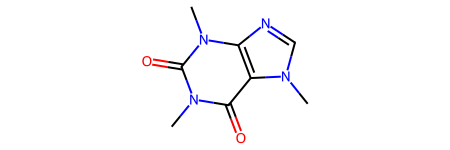

In [5]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw, AllChem
IPythonConsole.ipython_useSVG=True 
Chem.MolFromSmiles("CN1C=NC2=C1C(=O)N(C(=O)N2C)C")


In [6]:
#Center output
#from IPython.display import display, HTML
CSS = """
.output {
    align-items: center;
}
"""
#HTML('<style>{}</style>'.format(CSS))

# Enables large output display
#from IPython.core.display import display, HTML
#display(HTML("<style>div.output_scroll { height: 44em; }</style>"))

#from google.colab import data_table
#data_table.enable_dataframe_formatter()

from IPython.display import display, HTML

def show(obj):
  display(HTML(obj.to_html(escape=False)))


In [7]:
# First we need to load in the data from the fluid notebook
# TODO setup script to generate and then pull data from fluid notebook
# then load data



In [8]:
from IPython.display import display
import FLuID as fluid
import plotly.express as px
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings('ignore')


# import parameters ### TODO actually extract parameters to a separate file

import parameters.base_parameters as parameters

print(parameters.lhasa_params)


k = 8

params = {
    
    # experiment details
    'details' : 3,                  # level of detail of the experiment (low=1,medium=2,high=3,full=4)
    
    # datafiles
'training_data_file' : 'hERG_lhasa_training',
    'test_data_file' : 'hERG_lhasa_test',
'transfer_data_file' : 'FLuID_full',
  'fluid_label_file' : 'FLuID_labels',
    
    # data sampling
   'validation_ratio': 0.2,         # ratio validation/training
     'transfer_size' : 50000 ,      # sample for the transfer data (-1 = all)
         'test_size' : -1,          # sample for the test data (-1 = all)
     'training_size' : -1,          # sample for the training data (-1 = all)

    # number of teacher/clusters (kMean)
                 'k' : k,           # number of clusters (kMean)
     'smooth_factor' : 0.05,        # level of post-clustering mixing to avoid fully biased teachers
    
    # teachers
 'teacher_algorithm' : 'rf',        # algorithm used to build the teacher models
    
    # students
 'federated_student' : 'F' + str(k),
      'student_size' : 10000,                                              # size of the student (number of labelled Cronos data used)
      'student_sizes' : [100,250,500, 1000,2500,5000,10000,25000,50000],   # sizes of the student ti study the impact of the size
 'student_algorithm' : 'rf',                                               # default algorithm used to build the student models
      'student_mode' : 'balanced',                                         # default mode used to select the student data 
    
    # random seed for reproductibility
      'random_state' : 42,

    # t-SNE settings
         'tsne_size' : 500,
   'tsne_iterations' : 1000,
    
    # replication level
    'replicate_count' : 3,
    
    # fonts
       'figure_font' : dict(family="Arial",size=14,color="black"),
 'small_figure_font' : dict(family="Arial",size=10,color="black"),

    # colors
'figure_color_scale' : [(0,"red"),(0.2,"orange"), (0.3,'yellow'),(1,'green')],
        'bar_colors' : px.colors.qualitative.Prism,
         'green_map' : plt.get_cmap('Greens')
}

base_params = params.copy()


base_params["FP_type"] = "ECFP4"
base_params["FP_radius"] = 2
base_params["FP_length"] = 2**11


base_params["regressor_layers"] = [base_params["FP_length"], 
                                   base_params["FP_length"], 
                                   base_params["FP_length"]//2**2, 
                                   base_params["FP_length"]//2**4, 
                                   1] # slightly modified from the paper to use powers of 2 for convenience
base_params["regressor_dropout"] = [0.33] # taken from paper
base_params["max_epochs"] = 100
base_params["batch_size"] = 2**7
base_params["learning_rate"] = 10**-4 ### TODO Check this is correct - find this from the paper
base_params["weight_decay"] = 10**-1
base_params["convergence_threshold"] = 0.01

base_params["convergence_criterion"] = ""

base_params["base_checkpoint_dir"] = "model_checkpoints"
base_params["base_results_dir"] = "model_results"
os.makedirs(base_params["base_results_dir"] , exist_ok=True)

base_params["data_dir"] = "data"

for dataset in ["training_data", "test_data", "transfer_data", "validation_data", "label_table", "federated_data"]:
  base_params[dataset] = os.path.join(base_params["data_dir"], dataset + ".pkl")


FT_params = base_params.copy()



{'details': 3, 'training_data_file': 'hERG_lhasa_training', 'test_data_file': 'hERG_lhasa_test', 'transfer_data_file': 'FLuID_full', 'fluid_label_file': 'FLuID_labels', 'validation_ratio': 0.2, 'transfer_size': 50000, 'test_size': -1, 'training_size': -1, 'k': 8, 'smooth_factor': 0.05, 'teacher_algorithm': 'rf', 'federated_student': 'F8', 'student_size': 10000, 'student_sizes': [100, 250, 500, 1000, 2500, 5000, 10000, 25000, 50000], 'student_algorithm': 'rf', 'student_mode': 'balanced', 'random_state': 42, 'tsne_size': 500, 'tsne_iterations': 1000, 'replicate_count': 3, 'figure_font': {'family': 'Arial', 'size': 14, 'color': 'black'}, 'small_figure_font': {'family': 'Arial', 'size': 10, 'color': 'black'}, 'figure_color_scale': [(0, 'red'), (0.2, 'orange'), (0.3, 'yellow'), (1, 'green')], 'bar_colors': ['rgb(95, 70, 144)', 'rgb(29, 105, 150)', 'rgb(56, 166, 165)', 'rgb(15, 133, 84)', 'rgb(115, 175, 72)', 'rgb(237, 173, 8)', 'rgb(225, 124, 5)', 'rgb(204, 80, 62)', 'rgb(148, 52, 110)', 'r

In [9]:
import importlib
importlib.reload(fluid)
import numpy as np



In [10]:
### Load datasets -- TODO make this a seperate script to pull from fluid notebook

# Federated - load in transfer data
federated_data = pd.read_pickle(base_params["federated_data"])

# Clean - load in training data
clean_data = pd.read_pickle(base_params["training_data"])

# Validation - load in validation data
validation_data = pd.read_pickle(base_params["validation_data"])


# Target - load in test data
target_data = pd.read_pickle(base_params["test_data"])


#pre calculate fingerprints for all molecules

### Currently just computed within the fluid notebook


### split the data into training and validation sets

### Currently just using the split from the fluid notebook

In [11]:
federated_data.CLASS.to_numpy()

array([0, 0, 0, ..., 0, 0, 0])

In [190]:
import numpy as np
from torch.nn.modules.module import Module
from torch import nn 
import torch.nn.functional as F

from data_test_utils import MyDataset



ImportError: cannot import name 'calculate_tanimoto_similarity' from 'utils' (/Users/alexi/Library/CloudStorage/OneDrive-Nexus365/Rotation Projects/Rotation_1/Project/DomAdpQSAR/utils.py)

In [13]:
# Generate model 

# load Classifier???
from models import Classifier

model = Classifier()

print(model.parameters)

<bound method Module.parameters of Classifier(
  (hidden): ModuleList(
    (0): Linear(in_features=2048, out_features=2048, bias=True)
    (1): Linear(in_features=2048, out_features=512, bias=True)
    (2): Linear(in_features=512, out_features=128, bias=True)
  )
  (batchnorm): ModuleList(
    (0): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (output): Linear(in_features=128, out_features=1, bias=True)
)>


In [14]:
# from torch.utils.data import Dataset

# class MyDataset(Dataset):
#     def __init__(self, dataframe):
#         self.dataframe = dataframe
#         self.fp = self.dataframe['FP'].to_numpy()
#         self.labels = self.dataframe['CLASS'].to_numpy()

#     def __len__(self):
#         return len(self.dataframe)

#     def __getitem__(self, index):
#         x = torch.tensor(self.fp[index], dtype=torch.float32, device=device)
#         y = torch.tensor(self.labels[index], dtype=torch.float32, device=device)
#         return x, y


In [199]:
# broad tuning on federated dataset
FT_params["experiment_name"] = "broad_tuning"
FT_params["checkpoint_dir"] = os.path.join(FT_params["base_checkpoint_dir"], FT_params["experiment_name"])
# make directory for checkpoints
os.makedirs(FT_params["checkpoint_dir"], exist_ok=True)

from torch.utils.data import DataLoader

# create a dataloader for the federated data

N = 2**10


federated_loader = MyDataset(federated_data)
validation_loader = MyDataset(validation_data)
training_loader = MyDataset(clean_data)
testing_loader = MyDataset(target_data)

N = 25000
federated_loader = DataLoader(federated_loader, batch_size=N, shuffle=True)

N = 128
validation_loader = DataLoader(validation_loader, batch_size=N, shuffle=True)
training_loader = DataLoader(training_loader, batch_size=N, shuffle=True)
testing_loader = DataLoader(testing_loader, batch_size=N, shuffle=True)

In [17]:
for idx, layer in enumerate(base_params["regressor_layers"]):
    print(idx, layer)

0 2048
1 2048
2 512
3 128
4 1


In [18]:
from models import save_model, load_model

In [213]:
import torch
import torch.optim as optim

import numpy as np
from torch.nn.modules.module import Module
from torch import nn 
import torch.nn.functional as F


from models import train_model

In [21]:
from utils import calculate_tanimoto_similarity, calculate_target_similarity, calculate_set_similarity

In [191]:
from data_test_utils import dataset_compiler, plot_losses

ImportError: cannot import name 'calculate_tanimoto_similarity' from 'utils' (/Users/alexi/Library/CloudStorage/OneDrive-Nexus365/Rotation Projects/Rotation_1/Project/DomAdpQSAR/utils.py)

In [217]:
base_params["experiment_name"] = "broad_tuning"
base_params["checkpoint_dir"] = os.path.join(base_params["base_checkpoint_dir"], base_params["experiment_name"])
os.makedirs(base_params["checkpoint_dir"], exist_ok=True)
base_params["experiment_name"] = "broad_lr_1e-4_wd_0.1"
base_params["learning_rate"] = 10**-3 ### TODO Check this is correct - find this from the paper
base_params["weight_decay"] = 10**-0
model = Classifier()
model, train_losses, val_losses = train_model(model, federated_loader, validation_loader, num_epochs=50, lr=base_params["learning_rate"])
plot_losses([train_losses, val_losses], title="Losses on federated dataset")
# save_model(model, params=base_params)

torch.Size([25000, 2048])
torch.Size([25000, 2048])


ValueError: too many values to unpack (expected 2)

In [201]:
for data in validation_loader:
    print(data[0].shape)

torch.Size([128, 2048])
torch.Size([128, 2048])
torch.Size([128, 2048])
torch.Size([128, 2048])
torch.Size([128, 2048])
torch.Size([128, 2048])
torch.Size([128, 2048])
torch.Size([128, 2048])
torch.Size([128, 2048])
torch.Size([128, 2048])
torch.Size([128, 2048])
torch.Size([128, 2048])
torch.Size([18, 2048])


cpu
Epoch 1: Train loss = 30.0454, Val loss = 0.5467
Epoch 2: Train loss = 23.9517, Val loss = 0.4644
Epoch 3: Train loss = 20.4850, Val loss = 0.4257
Epoch 4: Train loss = 17.9886, Val loss = 0.4086
Epoch 5: Train loss = 15.2451, Val loss = 0.4099
Epoch 6: Train loss = 12.6644, Val loss = 0.4041
Epoch 7: Train loss = 11.0391, Val loss = 0.4104
Epoch 8: Train loss = 9.5854, Val loss = 0.4216
Epoch 9: Train loss = 8.0516, Val loss = 0.4469
Epoch 10: Train loss = 7.2217, Val loss = 0.5077
Epoch 11: Train loss = 6.1134, Val loss = 0.5077
Epoch 12: Train loss = 5.8372, Val loss = 0.5297
Epoch 13: Train loss = 5.2040, Val loss = 0.5137
Epoch 14: Train loss = 4.8327, Val loss = 0.5589
Epoch 15: Train loss = 4.2806, Val loss = 0.5417
Epoch 16: Train loss = 4.0684, Val loss = 0.5976
Epoch 17: Train loss = 4.0197, Val loss = 0.6202
Epoch 18: Train loss = 3.4397, Val loss = 0.6026
Epoch 19: Train loss = 3.4991, Val loss = 0.6337
Epoch 20: Train loss = 3.0731, Val loss = 0.6310
Epoch 21: Train lo

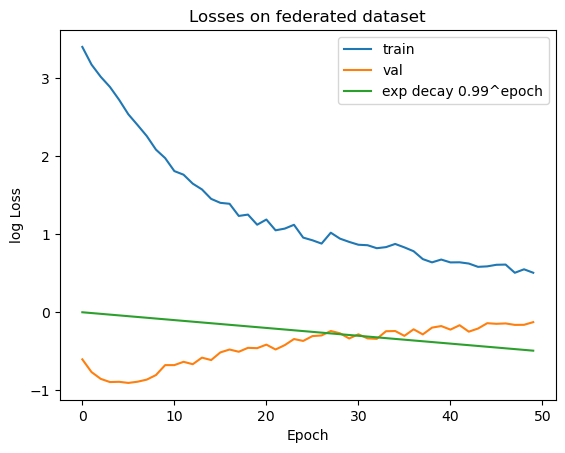

<Axes: title={'center': 'Losses on federated dataset'}, xlabel='Epoch', ylabel='log Loss'>

In [89]:
base_params["experiment_name"] = "broad_tuning"
base_params["checkpoint_dir"] = os.path.join(base_params["base_checkpoint_dir"], base_params["experiment_name"])
os.makedirs(base_params["checkpoint_dir"], exist_ok=True)
base_params["experiment_name"] = "broad_lr_1e-4_wd_0.1"
base_params["learning_rate"] = 10**-4 ### TODO Check this is correct - find this from the paper

model = Classifier()
model, train_losses, val_losses = train_model(model, training_loader, validation_loader, num_epochs=50, lr=base_params["learning_rate"])
plot_losses([train_losses, val_losses], title="Losses on federated dataset")
# save_model(model, params=base_params)

[2048, 512, 64, 32, 1]
Classifier(
  (hidden): ModuleList(
    (0): Linear(in_features=2048, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=64, bias=True)
    (2): Linear(in_features=64, out_features=32, bias=True)
  )
  (batchnorm): ModuleList(
    (0): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (output): Linear(in_features=32, out_features=1, bias=True)
)
cpu
Epoch 1: Train loss = 1.6082, Val loss = 0.7069, Val accuracy = 58.5740
Epoch 2: Train loss = 1.5957, Val loss = 0.7067, Val accuracy = 58.6448
Epoch 3: Train loss = 1.5852, Val loss = 0.7046, Val accuracy = 58.5032
Epoch 4: Train loss = 1.5763, Val loss = 0.7076, Val accuracy = 58.8571
Epoch 5: Train loss = 1.5685, Val loss = 0.7032, Val accuracy = 58.4324
Epoch 6: Train loss = 1.56

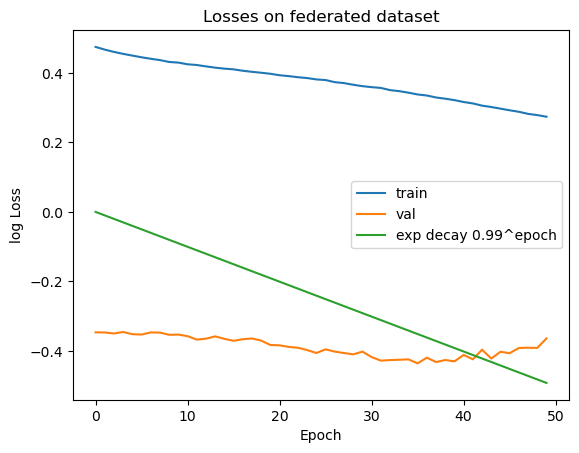

cpu
Epoch 1: Train loss = 29.0650, Val loss = 0.5404, Val accuracy = 64.6010
Epoch 2: Train loss = 25.3951, Val loss = 0.5012, Val accuracy = 64.4221
Epoch 3: Train loss = 22.7371, Val loss = 0.4786, Val accuracy = 64.0978
Epoch 4: Train loss = 20.6787, Val loss = 0.4390, Val accuracy = 64.2651
Epoch 5: Train loss = 18.8710, Val loss = 0.4361, Val accuracy = 64.2690
Epoch 6: Train loss = 17.1481, Val loss = 0.4322, Val accuracy = 64.5122
Epoch 7: Train loss = 15.6416, Val loss = 0.4230, Val accuracy = 63.8430
Epoch 8: Train loss = 14.4011, Val loss = 0.4500, Val accuracy = 63.5985
Epoch 9: Train loss = 13.5858, Val loss = 0.4365, Val accuracy = 63.8134
Epoch 10: Train loss = 13.0796, Val loss = 0.4458, Val accuracy = 64.1197
Epoch 11: Train loss = 12.5325, Val loss = 0.4402, Val accuracy = 63.9537
Epoch 12: Train loss = 11.8380, Val loss = 0.4654, Val accuracy = 64.1815
Epoch 13: Train loss = 11.1673, Val loss = 0.4635, Val accuracy = 63.7748
Epoch 14: Train loss = 10.7432, Val loss = 

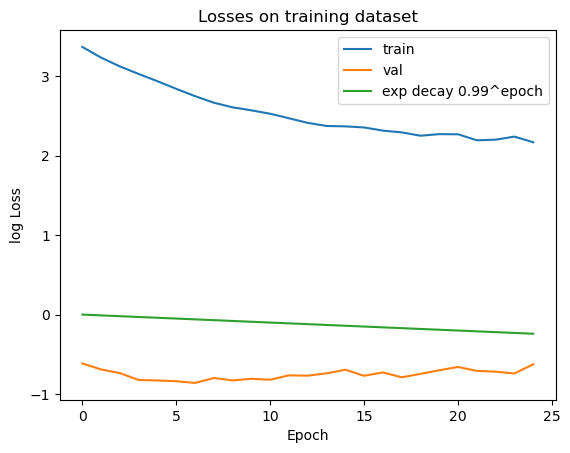

In [94]:

layer_exponents = [[11,9,6,5,0]]

base_params["learning_rate"] = 0.0004666035758265102 ### TODO Check this is correct - find this from the paper
base_params["learning_rate"] = 0.001 ### TODO Check this is correct - find this from the paper
base_params["learning_rate"] = 0.0001388098934176529

base_params["weight_decay"] = 0.
base_params["weight_decay"] = 0.7948575299233199### TODO Check this is correct - find this from the paper
base_params["weight_decay"] = 0.05271460721848545
for exp in layer_exponents:

    layer_sizes = [int(2**i) for i in exp]
    
    print(layer_sizes)
    model = Classifier(layer_sizes)
    print(model)
    model, train_losses, val_losses = train_model(model, federated_loader, validation_loader, num_epochs=25, lr=base_params["learning_rate"], weight_decay=base_params["weight_decay"])
    plot_losses([train_losses, val_losses], title="Losses on federated dataset")
    model, train_losses, val_losses = train_model(model, training_loader, validation_loader, num_epochs=25, lr=base_params["learning_rate"], weight_decay=base_params["weight_decay"])
    plot_losses([train_losses, val_losses], title="Losses on training dataset")







In [46]:

layer_exponents = [[11,3,2,1,0],
                   [11,5,3,2,0],
                   [11,5,4,0],
                    [11,5,2,0],
                    [11,3,2,0],
                    [11,3,0]]
base_params["learning_rate"] = 10**-3 ### TODO Check this is correct - find this from the paper
# base_params["weight_decay"] = 0.1 ### TODO Check this is correct - find this from the paper
for exp in layer_exponents:

    layer_sizes = [2**i for i in exp]
    print(layer_sizes)
    model = Classifier(layer_sizes)
    print(model)
    model, train_losses, val_losses = train_model(model, federated_loader, validation_loader, num_epochs=25, lr=base_params["learning_rate"], weight_decay=base_params["weight_decay"])
    plot_losses([train_losses, val_losses], title="Losses on federated dataset")







[2048, 8, 4, 2, 1]
Classifier(
  (hidden): ModuleList(
    (0): Linear(in_features=2048, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=4, bias=True)
    (2): Linear(in_features=4, out_features=2, bias=True)
  )
  (batchnorm): ModuleList(
    (0): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (output): Linear(in_features=2, out_features=1, bias=True)
)
cpu


TypeError: 'DataLoader' object is not subscriptable

[2048, 8192, 512, 128, 1]
Classifier(
  (hidden): ModuleList(
    (0): Linear(in_features=2048, out_features=8192, bias=True)
    (1): Linear(in_features=8192, out_features=512, bias=True)
    (2): Linear(in_features=512, out_features=128, bias=True)
  )
  (batchnorm): ModuleList(
    (0): BatchNorm1d(8192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (output): Linear(in_features=128, out_features=1, bias=True)
)
cpu
Epoch 1: Train loss = 29.4105, Val loss = 0.6805, Val accuracy = 0.5380
Epoch 2: Train loss = 28.8018, Val loss = 0.5719, Val accuracy = 0.5380
Epoch 3: Train loss = 29.1730, Val loss = 0.6806, Val accuracy = 0.5380
Epoch 4: Train loss = 29.5968, Val loss = 0.6239, Val accuracy = 0.5380
Epoch 5: Train loss = 29.8353, Val loss = 0.6173, Val accuracy = 0.5380
Epoch 6: Train

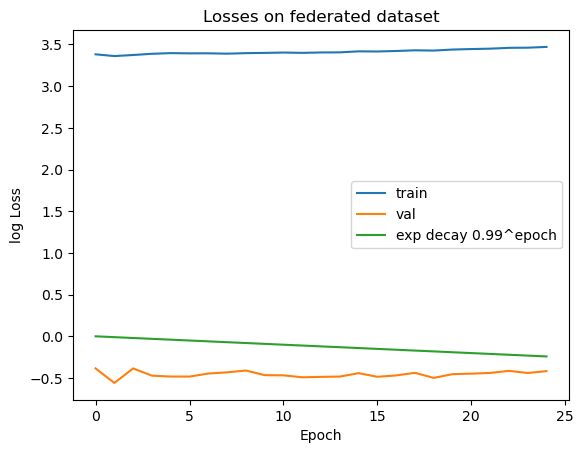

[2048, 32768, 512, 64, 1]
Classifier(
  (hidden): ModuleList(
    (0): Linear(in_features=2048, out_features=32768, bias=True)
    (1): Linear(in_features=32768, out_features=512, bias=True)
    (2): Linear(in_features=512, out_features=64, bias=True)
  )
  (batchnorm): ModuleList(
    (0): BatchNorm1d(32768, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (output): Linear(in_features=64, out_features=1, bias=True)
)
cpu
Epoch 1: Train loss = 29.6451, Val loss = 0.6715, Val accuracy = 0.5380
Epoch 2: Train loss = 29.7059, Val loss = 0.6697, Val accuracy = 0.5380
Epoch 3: Train loss = 30.0973, Val loss = 0.6279, Val accuracy = 0.5380
Epoch 4: Train loss = 30.1323, Val loss = 0.6368, Val accuracy = 0.5380
Epoch 5: Train loss = 30.2823, Val loss = 0.6962, Val accuracy = 0.5380
Epoch 6: Train

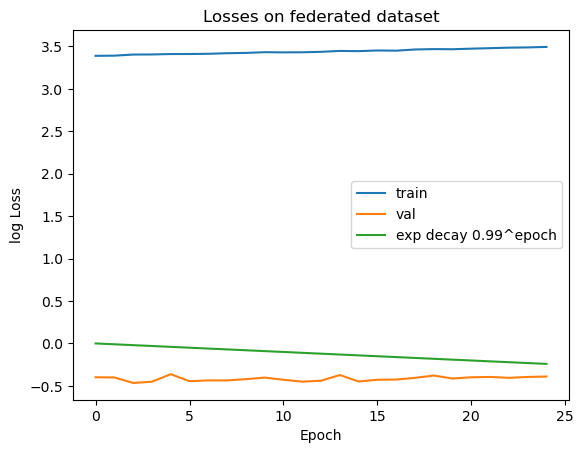

[2048, 512, 128, 32, 1]
Classifier(
  (hidden): ModuleList(
    (0): Linear(in_features=2048, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=128, bias=True)
    (2): Linear(in_features=128, out_features=32, bias=True)
  )
  (batchnorm): ModuleList(
    (0): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (output): Linear(in_features=32, out_features=1, bias=True)
)
cpu
Epoch 1: Train loss = 30.2358, Val loss = 0.6678, Val accuracy = 0.5380
Epoch 2: Train loss = 28.6773, Val loss = 0.5913, Val accuracy = 0.5380
Epoch 3: Train loss = 29.0800, Val loss = 0.5835, Val accuracy = 0.5380
Epoch 4: Train loss = 29.1538, Val loss = 0.6011, Val accuracy = 0.5380
Epoch 5: Train loss = 29.0101, Val loss = 0.5654, Val accuracy = 0.5380
Epoch 6: Train loss = 

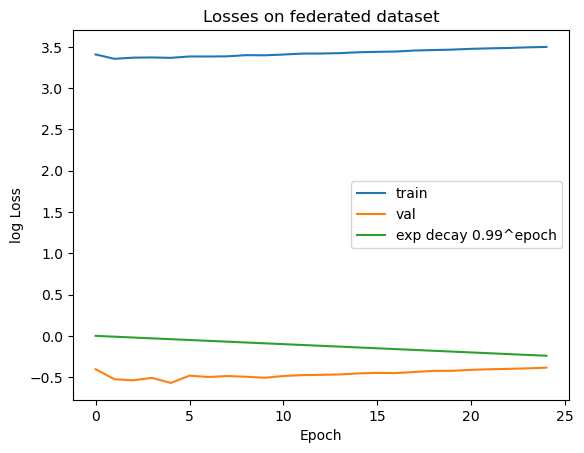

[2048, 512, 128, 1]
Classifier(
  (hidden): ModuleList(
    (0): Linear(in_features=2048, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=128, bias=True)
  )
  (batchnorm): ModuleList(
    (0): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (output): Linear(in_features=128, out_features=1, bias=True)
)
cpu
Epoch 1: Train loss = 28.5267, Val loss = 0.6533, Val accuracy = 0.5380
Epoch 2: Train loss = 27.5538, Val loss = 0.5749, Val accuracy = 0.5380
Epoch 3: Train loss = 27.8058, Val loss = 0.5831, Val accuracy = 0.5380
Epoch 4: Train loss = 27.8825, Val loss = 0.5726, Val accuracy = 0.5380
Epoch 5: Train loss = 27.8925, Val loss = 0.5725, Val accuracy = 0.5380
Epoch 6: Train loss = 27.8834, Val loss = 0.5580, Val accuracy = 0.5380
Epoch 7: Train loss = 28.1049, Val loss = 0.5984, Val accuracy = 0.5380
Epoch 8: Train loss = 28.2898, 

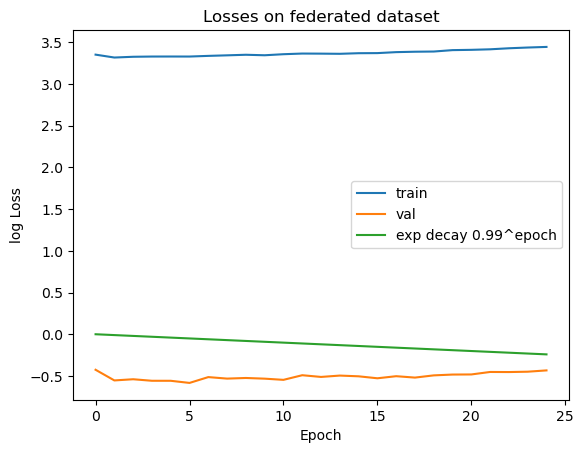

[2048, 512, 32, 1]
Classifier(
  (hidden): ModuleList(
    (0): Linear(in_features=2048, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=32, bias=True)
  )
  (batchnorm): ModuleList(
    (0): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (output): Linear(in_features=32, out_features=1, bias=True)
)
cpu
Epoch 1: Train loss = 29.0110, Val loss = 0.6474, Val accuracy = 0.5380
Epoch 2: Train loss = 27.9814, Val loss = 0.6028, Val accuracy = 0.5380
Epoch 3: Train loss = 28.5300, Val loss = 0.5749, Val accuracy = 0.5380
Epoch 4: Train loss = 28.6694, Val loss = 0.5820, Val accuracy = 0.5380
Epoch 5: Train loss = 28.9480, Val loss = 0.6125, Val accuracy = 0.5380
Epoch 6: Train loss = 29.1956, Val loss = 0.6046, Val accuracy = 0.5380
Epoch 7: Train loss = 29.4191, Val loss = 0.5994, Val accuracy = 0.5380
Epoch 8: Train loss = 29.5398, Val 

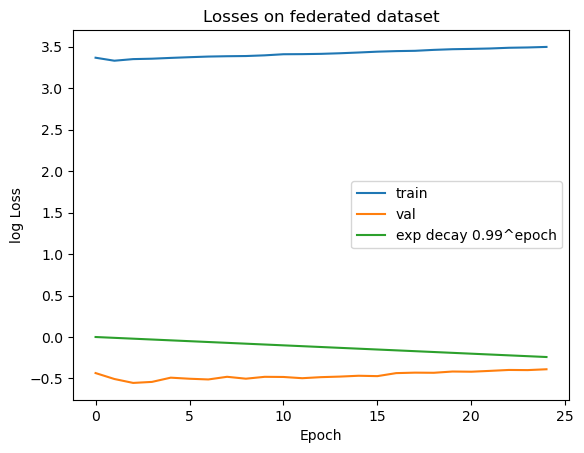

[2048, 8, 1]
Classifier(
  (hidden): ModuleList(
    (0): Linear(in_features=2048, out_features=8, bias=True)
  )
  (batchnorm): ModuleList(
    (0): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (output): Linear(in_features=8, out_features=1, bias=True)
)
cpu
Epoch 1: Train loss = 30.3660, Val loss = 0.6172, Val accuracy = 0.5380
Epoch 2: Train loss = 28.3519, Val loss = 0.5662, Val accuracy = 0.5380
Epoch 3: Train loss = 28.6561, Val loss = 0.5963, Val accuracy = 0.5380
Epoch 4: Train loss = 29.2684, Val loss = 0.5918, Val accuracy = 0.5380
Epoch 5: Train loss = 29.7267, Val loss = 0.6003, Val accuracy = 0.5380
Epoch 6: Train loss = 30.0527, Val loss = 0.6105, Val accuracy = 0.5380
Epoch 7: Train loss = 30.4878, Val loss = 0.6186, Val accuracy = 0.5380
Epoch 8: Train loss = 30.7939, Val loss = 0.6238, Val accuracy = 0.5380
Epoch 9: Train loss = 31.0857, Val loss = 0.6307, Val accuracy = 0.5380
Epoch 10: Train loss = 31.3080, Val loss = 0.6379, V

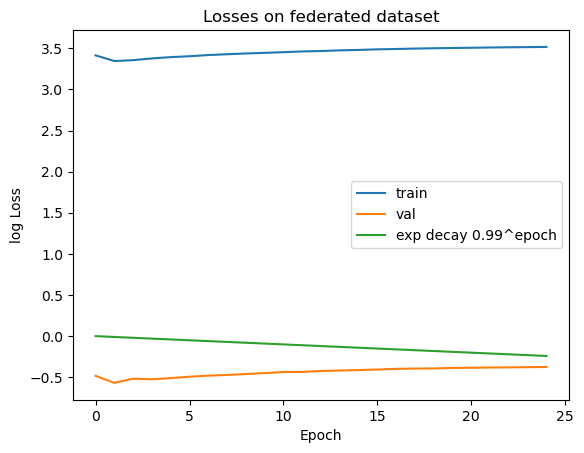

In [128]:

layer_exponents = [[11,13,9,7,0],
                   [11,15,9,6,0],
                   [11,9,7,5,0],
                    [11,9,7,0],
                    [11,9,5,0],
                    [11,3,0]]
base_params["learning_rate"] = 10**-3 ### TODO Check this is correct - find this from the paper
# base_params["weight_decay"] = 0.1 ### TODO Check this is correct - find this from the paper
for exp in layer_exponents:

    layer_sizes = [2**i for i in exp]
    print(layer_sizes)
    model = Classifier(layer_sizes)
    print(model)
    model, train_losses, val_losses = train_model(model, training_loader, validation_loader, num_epochs=25, lr=base_params["learning_rate"], weight_decay=base_params["weight_decay"])
    plot_losses([train_losses, val_losses], title="Losses on federated dataset")







cpu
Epoch 1: Train loss = 1.4327, Val loss = 0.6942, Val accuracy = 0.5380
Epoch 2: Train loss = 1.4306, Val loss = 0.6937, Val accuracy = 0.5380
Epoch 3: Train loss = 1.4277, Val loss = 0.6938, Val accuracy = 0.5380
Epoch 4: Train loss = 1.4237, Val loss = 0.6927, Val accuracy = 0.5380
Epoch 5: Train loss = 1.4221, Val loss = 0.6942, Val accuracy = 0.5380
Epoch 6: Train loss = 1.4210, Val loss = 0.6935, Val accuracy = 0.5380
Epoch 7: Train loss = 1.4171, Val loss = 0.6926, Val accuracy = 0.5380
Epoch 8: Train loss = 1.4150, Val loss = 0.6922, Val accuracy = 0.5380
Epoch 9: Train loss = 1.4122, Val loss = 0.6925, Val accuracy = 0.5380
Epoch 10: Train loss = 1.4099, Val loss = 0.6911, Val accuracy = 0.5380
Epoch 11: Train loss = 1.4077, Val loss = 0.6908, Val accuracy = 0.5380
Epoch 12: Train loss = 1.4067, Val loss = 0.6900, Val accuracy = 0.5380
Epoch 13: Train loss = 1.4043, Val loss = 0.6898, Val accuracy = 0.5380
Epoch 14: Train loss = 1.4009, Val loss = 0.6906, Val accuracy = 0.53

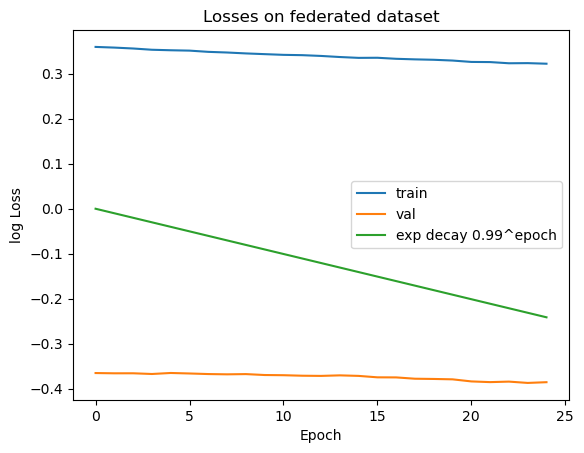

Model saved to model_checkpoints/broad_tuning/broad_lr_1e-4_wd_0.1_2023-04-28_10-59-00.pt


'model_checkpoints/broad_tuning/broad_lr_1e-4_wd_0.1_2023-04-28_10-59-00.pt'

In [126]:
# base_params["weight_decay"]=0.1
base_params["learning_rate"]=1e-4

# train the model

# from models import train_model
model = Classifier([2048, 8, 1])

model, train_losses, val_losses = train_model(model, federated_loader, validation_loader, num_epochs=25, lr=base_params["learning_rate"],weight_decay=base_params["weight_decay"])
plot_losses([train_losses, val_losses], title="Losses on federated dataset")

save_model(model, params=base_params)

In [ ]:
base_params["weight_decay"]=0.1
base_params["learning_rate"]=1e-4

# train the model
 
# from models import train_model
model = Classifier()

model, train_losses, val_losses = train_model(model, federated_loader, validation_loader, num_epochs=100, lr=base_params["learning_rate"],weight_decay=base_params["weight_decay"])
plot_losses([train_losses, val_losses], title="Losses on federated dataset")

save_model(model, params=base_params)

In [ ]:
base_params["weight_decay"]=0.1
base_params["learning_rate"]=1e-5
base_params["experiment_name"] = "broad_lr_1e-5_wd_0.1"
# train the model
model = Classifier()

# from models import train_model

model, train_losses, val_losses = train_model(model, federated_loader, validation_loader, num_epochs=50, lr=base_params["learning_rate"],weight_decay=base_params["weight_decay"])
plot_losses([train_losses, val_losses], title="Losses on federated dataset")

save_model(model, params=base_params)

In [ ]:
base_params["weight_decay"]=0.1
base_params["learning_rate"]=1e-5
base_params["experiment_name"] = "lr_1e-1_wd_0.1_clean_only_25k"
# train the model
model = Classifier()

# from models import train_model

model, train_losses, val_losses = train_model(model, training_loader, validation_loader, num_epochs=100, lr=base_params["learning_rate"],weight_decay=base_params["weight_decay"])
plot_losses([train_losses, val_losses], title="Losses on training dataset")

save_model(model, params=base_params)

In [ ]:
### Save model
plot_losses([train_losses, val_losses])

In [ ]:
plot_losses([train_losses, val_losses], logscale=False)

In [ ]:

save_model(model, FT_params)

In [ ]:
model = load_model(model, FT_params["checkpoint_dir"], latest=True)

In [ ]:
# Hyperparameter search with Ax - being done in seperate notebook
print("model")
for idx, param in enumerate(model.parameters()):
    print(idx, param.requires_grad, param.shape)

print("hidden")
for idx, param in enumerate(model.hidden.parameters()):
    print(idx, param.requires_grad, param.shape)

print("batchnorm")
for idx, param in enumerate(model.batchnorm.parameters()):
    print(idx, param.requires_grad, param.shape)

print("output")
for idx, param in enumerate(model.output.parameters()):
    print(idx, param.requires_grad, param.shape)

In [ ]:
for item in model:
    print(item)

In [ ]:
FT_EPOCHS = 100

In [ ]:
# no broad tuning

# load model
model = Classifier()
# change params
FT_params["experiment_name"] = "clean_only"
FT_params["checkpoint_dir"] = os.path.join(FT_params["base_checkpoint_dir"], FT_params["experiment_name"])
# make directory for checkpoints
os.makedirs(FT_params["checkpoint_dir"], exist_ok=True)


FT_model, train_losses, val_losses = train_model(model, training_loader, validation_loader, num_epochs=FT_EPOCHS, lr=base_params["learning_rate"])

save_model(FT_model, params=FT_params)
plot_losses([train_losses, val_losses])

In [ ]:
# no broad tuning change lr to 1e-6 

# load model
model = Classifier()
# change params
FT_params["experiment_name"] = "clean_only"
FT_params["checkpoint_dir"] = os.path.join(FT_params["base_checkpoint_dir"], FT_params["experiment_name"])
# make directory for checkpoints
os.makedirs(FT_params["checkpoint_dir"], exist_ok=True)


FT_model, train_losses, val_losses = train_model(model, training_loader, validation_loader, num_epochs=FT_EPOCHS, lr=base_params["learning_rate"])

save_model(FT_model, params=FT_params)
plot_losses([train_losses, val_losses])

In [ ]:
# fine tuning on clean dataset
FT_params["experiment_name"] = "broad_tuning"
FT_params["checkpoint_dir"] = os.path.join(FT_params["base_checkpoint_dir"], FT_params["experiment_name"])

# load model
model = load_model(model, FT_params["checkpoint_dir"], latest=True)
# change params
FT_params["experiment_name"] = "FT_clean"
FT_params["checkpoint_dir"] = os.path.join(FT_params["base_checkpoint_dir"], FT_params["experiment_name"])
# make directory for checkpoints
os.makedirs(FT_params["checkpoint_dir"], exist_ok=True)


FT_model, train_losses, val_losses = train_model(model, training_loader, validation_loader, num_epochs=FT_EPOCHS, lr=base_params["learning_rate"])

save_model(FT_model, params=FT_params)
plot_losses([train_losses, val_losses])

In [ ]:
# compare the effect on batch sizes on training speed and accuracy
times = []
final_train_losses = []
final_val_losses = []
batch_sizes = []

import time

for index in range(10, 16):
    
    batch_size = 2**index
    batch_sizes.append(batch_size)

    print(batch_size)
    # create empty model
    model = Classifier()
    # change params in datasets
    N = batch_size


    federated_loader = MyDataset(federated_data)
    validation_loader = MyDataset(validation_data)
    training_loader = MyDataset(clean_data)
    testing_loader = MyDataset(target_data)


    federated_loader = DataLoader(federated_loader, batch_size=N, shuffle=True)
    validation_loader = DataLoader(validation_loader, batch_size=N, shuffle=True)
    training_loader = DataLoader(training_loader, batch_size=N, shuffle=True)
    testing_loader = DataLoader(testing_loader, batch_size=N, shuffle=True)

    # start timer
    start = time.time()

    # train the model for 10 epochs

    model, train_losses, val_losses = train_model(model, federated_loader, validation_loader, num_epochs=5, lr=base_params["learning_rate"])
    # end timer
    end = time.time()

    # append time to list
    print(end-start)

    plot_losses([train_losses, val_losses])

    times.append(end-start)

    # append final losses to list
    final_train_losses.append(train_losses[-1])
    final_val_losses.append(val_losses[-1])

# plot the results batch size vs time
plt.plot(batch_sizes, times)
plt.xlabel("Batch size")
plt.ylabel("Time (s)")
plt.title("Batch size vs time")
plt.show()

# plot the results batch size vs loss
plt.plot(batch_sizes, final_train_losses, label="Training loss")
plt.plot(batch_sizes, final_val_losses, label="Validation loss")
plt.xlabel("Batch size")
plt.ylabel("Loss")
plt.title("Batch size vs loss")
plt.legend()
plt.show()






In [20]:

# function to freeze the layers of a model up to a certain layer index
def freeze_layers(model, layer_index):
    """
    Takes in a model and a layer index, and freezes the hidden layers up to that index
    """
    # accounts for layers and activations are in the same list as well as for 0 indexing
    layer_index = ((layer_index +1)*2)-1
    for i, param in enumerate(model.hidden.parameters()):
        if i > layer_index:
            param.requires_grad = False

    for i, param in enumerate(model.batchnorm.parameters()):
        if i > layer_index:
            param.requires_grad = False

    
    return model            


In [ ]:
# experiment freezing layers

FT_params["experiment_name"] = "broad_tuning"
FT_params["checkpoint_dir"] = os.path.join(FT_params["base_checkpoint_dir"], FT_params["experiment_name"])

# load model
model = load_model(model, FT_params["checkpoint_dir"], latest=True)

FT_params["experiment_name"] = "FT_clean_freeze_0"
FT_params["freeze_layers"] = 0
FT_params["checkpoint_dir"] = os.path.join(FT_params["base_checkpoint_dir"], FT_params["experiment_name"])
# make directory for checkpoints
os.makedirs(FT_params["checkpoint_dir"], exist_ok=True)

model = freeze_layers(model, FT_params["freeze_layers"])

FT_model, train_losses, val_losses = train_model(model, training_loader, validation_loader, num_epochs=FT_EPOCHS, lr=base_params["learning_rate"])

save_model(FT_model, params=FT_params)
plot_losses([train_losses, val_losses])

In [ ]:

FT_params["experiment_name"] = "broad_tuning"
FT_params["checkpointx_dir"] = os.path.join(FT_params["base_checkpoint_dir"], FT_params["experiment_name"])

# load model
model = load_model(model, FT_params["checkpoint_dir"], latest=True)

FT_params["experiment_name"] = "FT_clean_freeze_1"
FT_params["freeze_layers"] = 1
FT_params["checkpoint_dir"] = os.path.join(FT_params["base_checkpoint_dir"], FT_params["experiment_name"])
# make directory for checkpoints
os.makedirs(FT_params["checkpoint_dir"], exist_ok=True)

model = freeze_layers(model, FT_params["freeze_layers"])

FT_model, train_losses, val_losses = train_model(model, training_loader, validation_loader, num_epochs=FT_EPOCHS, lr=base_params["learning_rate"])

save_model(FT_model, params=FT_params)
plot_losses([train_losses, val_losses])

In [ ]:

FT_params["experiment_name"] = "broad_tuning"
FT_params["checkpoint_dir"] = os.path.join(FT_params["base_checkpoint_dir"], FT_params["experiment_name"])

# load model
model = load_model(model, FT_params["checkpoint_dir"], latest=True)

FT_params["experiment_name"] = "FT_clean_freeze_2"
FT_params["freeze_layers"] = 2
FT_params["checkpoint_dir"] = os.path.join(FT_params["base_checkpoint_dir"], FT_params["experiment_name"])
# make directory for checkpoints
os.makedirs(FT_params["checkpoint_dir"], exist_ok=True)

model = freeze_layers(model, FT_params["freeze_layers"])

FT_model, train_losses, val_losses = train_model(model, training_loader, validation_loader, num_epochs=FT_EPOCHS, lr=base_params["learning_rate"])

save_model(FT_model, params=FT_params)
plot_losses([train_losses, val_losses])

In [ ]:

FT_params["experiment_name"] = "broad_tuning"
FT_params["checkpoint_dir"] = os.path.join(FT_params["base_checkpoint_dir"], FT_params["experiment_name"])

# load model
model = load_model(model, FT_params["checkpoint_dir"], latest=True)

FT_params["experiment_name"] = "FT_clean_freeze_3"
FT_params["freeze_layers"] = 3
FT_params["checkpoint_dir"] = os.path.join(FT_params["base_checkpoint_dir"], FT_params["experiment_name"])
# make directory for checkpoints
os.makedirs(FT_params["checkpoint_dir"], exist_ok=True)

model = freeze_layers(model, FT_params["freeze_layers"])

FT_model, train_losses, val_losses = train_model(model, training_loader, validation_loader, num_epochs=FT_EPOCHS, lr=base_params["learning_rate"])

save_model(FT_model, params=FT_params)
plot_losses([train_losses, val_losses])

In [ ]:
plot_losses([train_losses, val_losses], logscale=False)

In [ ]:
# Gradual fine tuning to come later
import math
number_of_gradual_steps = math.log2(math.floor(len(federated_data)/len(clean_data)))

print(number_of_gradual_steps)

In [ ]:
# Gradual fine tuning testing - each finetuning step is 1/2 the size of the previous step for the federated dataset
# Each step we compile a dataset with the federated data and the clean data and then train the model on that dataset
import copy
# load in the broad tuned model
model = Classifier()
#create placeholder for grad_FT_model
Grad_FT_model = None

# broad tuning on federated dataset
base_params["experiment_name"] = "broad_tuning"
base_params["checkpoint_dir"] = os.path.join(base_params["base_checkpoint_dir"], base_params["experiment_name"])
learning_rate = 1e-4
weight_decay = 0.0

# model = load_model(model, base_params["checkpoint_dir"], latest=True)
model, train_losses, val_losses = train_model(model, federated_loader, validation_loader, num_epochs=20, lr=learning_rate, weight_decay=weight_decay)
plot_losses([train_losses, val_losses], title="Losses on compiled dataset")



# set the parameters for the gradual fine tuning
gradual_FT_params = copy.deepcopy(base_params)
gradual_FT_params["experiment_name"] = "gradual_FT"
gradual_FT_params["checkpoint_dir"] = os.path.join(gradual_FT_params["base_checkpoint_dir"], gradual_FT_params["experiment_name"])



gradual_FT_params["max_epochs"] = 10
batch_size = 2**10
learning_rate = 1e-3
weight_decay = 0.0
# make directory for checkpoints
os.makedirs(gradual_FT_params["checkpoint_dir"], exist_ok=True)

number_of_gradual_steps = int(math.log2(math.floor(len(federated_data)/len(clean_data))))

for i in range(number_of_gradual_steps):
    temp_params = copy.deepcopy(gradual_FT_params)
    if Grad_FT_model is not None:
        model = Grad_FT_model
    i = i+1
    # calcualate percentages for the datasets
    federated_percentage = 1/(2**i)
    clean_percentage = 1
    percentages = [federated_percentage, clean_percentage]
    # compile the dataset
    compiled_dataset = dataset_compiler(F_dataset=federated_data, S0_dataset=clean_data, percentages=percentages)
    compiled_loader = MyDataset(compiled_dataset)
    compiled_loader = DataLoader(compiled_loader, batch_size=batch_size, shuffle=True)

    
    # train the model using the compiled dataset
    temp_params["experiment_name"] = gradual_FT_params["experiment_name"] + "_step_{}".format(i)
    Grad_FT_model, train_losses, val_losses = train_model(model, compiled_loader, validation_loader, num_epochs=gradual_FT_params["max_epochs"], lr=learning_rate, weight_decay=weight_decay)

    plot_losses([train_losses, val_losses], title="Losses on compiled dataset"+" "+temp_params["experiment_name"])

    save_model(model, params=temp_params)


# final step with the clean data
temp_params["experiment_name"] = gradual_FT_params["experiment_name"] + "_step_{}".format(-1)

Grad_FT_model, train_losses, val_losses = train_model(model, training_loader, validation_loader, num_epochs=gradual_FT_params["max_epochs"], lr=1e-3)

plot_losses([train_losses, val_losses], title="Losses on compiled dataset"+" "+temp_params["experiment_name"])
save_model(model, params=temp_params)




Loading latest model from model_checkpoints/broad_tuning/broad_tuning_2023-04-25_11-18-38.pt
Initial size of dataset: 50000
Sampling 50.0% of the dataset
Final size of dataset: 25000
Initial size of dataset: 6218
Sampling 100% of the dataset
Final size of dataset: 6218
cpu
Epoch 1: Train loss = 69.4211, Val loss = 0.6875, Val accuracy = 0.5380
Final: Train loss = 69.4211, Val loss = 0.6875, Val accuracy = 0.5380


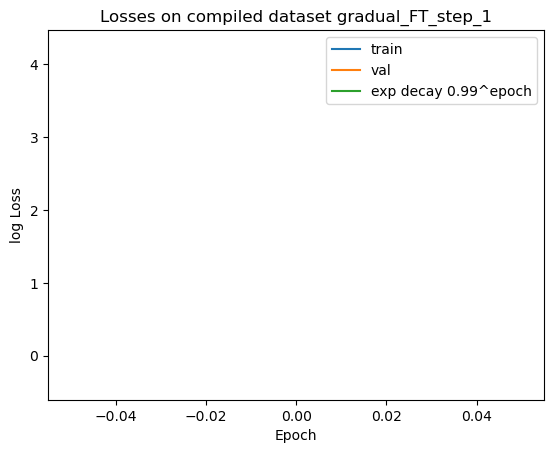

Model saved to model_checkpoints/gradual_FT/gradual_FT_step_1_2023-04-28_15-16-44.pt
Initial size of dataset: 50000
Sampling 25.0% of the dataset
Final size of dataset: 12500
Initial size of dataset: 6218
Sampling 100% of the dataset
Final size of dataset: 6218
cpu
Epoch 1: Train loss = 36.1130, Val loss = 0.6216, Val accuracy = 0.5380
Final: Train loss = 36.1130, Val loss = 0.6216, Val accuracy = 0.5380


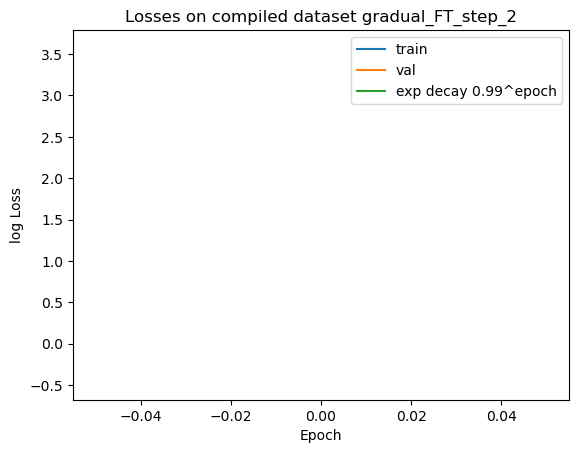

Model saved to model_checkpoints/gradual_FT/gradual_FT_step_2_2023-04-28_15-19-07.pt
Initial size of dataset: 50000
Sampling 12.5% of the dataset
Final size of dataset: 6250
Initial size of dataset: 6218
Sampling 100% of the dataset
Final size of dataset: 6218
cpu
Epoch 1: Train loss = 25.5601, Val loss = 0.6676, Val accuracy = 0.5380
Final: Train loss = 25.5601, Val loss = 0.6676, Val accuracy = 0.5380


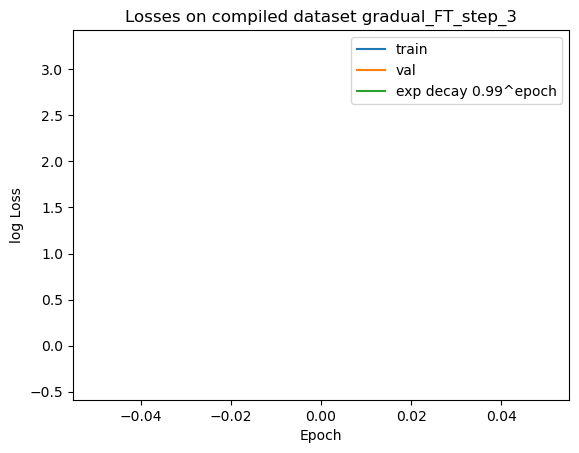

Model saved to model_checkpoints/gradual_FT/gradual_FT_step_3_2023-04-28_15-21-39.pt


NameError: name 'temp_params' is not defined

In [34]:
# Gradual fine tuning testing - each finetuning step is 1/2 the size of the previous step for the federated dataset
# Each step we compile a dataset with the federated data and the clean data and then train the model on that dataset
import copy
device = 'cpu'
# load in the broad tuned model
model = Classifier()
#create placeholder for grad_FT_model
Grad_FT_model = None

# broad tuning on federated dataset
base_params["experiment_name"] = "broad_tuning"
base_params["checkpoint_dir"] = os.path.join(base_params["base_checkpoint_dir"], base_params["experiment_name"])

model = load_model(model, base_params["checkpoint_dir"], latest=True)
# model, train_losses, val_losses = train_model(model, federated_loader, validation_loader, num_epochs=20, lr=learning_rate, weight_decay=weight_decay)
# plot_losses([train_losses, val_losses], title="Losses on compiled dataset")



# set the parameters for the gradual fine tuning
gradual_FT_params = copy.deepcopy(base_params)
gradual_FT_params["experiment_name"] = "gradual_FT"
gradual_FT_params["checkpoint_dir"] = os.path.join(gradual_FT_params["base_checkpoint_dir"], gradual_FT_params["experiment_name"])
gradual_FT_params["learning_rate"] = 1e-3
gradual_FT_params["weight_decay"] = 0.0
gradual_FT_params["max_epochs"] = 1
gradual_FT_params["rank"] = None

Grad_FT_model, train_losses, val_losses = gradual_fine_tuning(model, federated_data=federated_data, clean_data=clean_data, gradual_FT_params=gradual_FT_params, validation_loader=validation_loader)


# final step with the clean data

temp_params["experiment_name"] = gradual_FT_params["experiment_name"] + "_step_{}".format(-1)

Grad_FT_model, train_losses, val_losses = train_model(model, training_loader, validation_loader, num_epochs=gradual_FT_params["max_epochs"], lr=1e-3)

plot_losses([train_losses, val_losses], title="Losses on compiled dataset"+" "+temp_params["experiment_name"])
save_model(model, params=temp_params)




Loading latest model from model_checkpoints/broad_tuning/broad_tuning_2023-04-25_11-18-38.pt
Initial size of dataset: 50000
Sampling 50.0% of the dataset
Final size of dataset: 25000
Initial size of dataset: 6218
Sampling 100% of the dataset
Final size of dataset: 6218
cpu


TypeError: 'DataLoader' object is not subscriptable

In [ ]:
# Gradual fine tuning testing - each finetuning step is 1/2 the size of the previous step for the federated dataset
# Each step we compile a dataset with the federated data and the clean data and then train the model on that dataset
import copy
# load in the broad tuned model
model = Classifier()
#create placeholder for grad_FT_model
Grad_FT_model = None

# broad tuning on federated dataset
base_params["experiment_name"] = "broad_tuning"
base_params["checkpoint_dir"] = os.path.join(base_params["base_checkpoint_dir"], base_params["experiment_name"])
learning_rate = 1e-5
weight_decay = 0.1

# model = load_model(model, base_params["checkpoint_dir"], latest=True)
model, train_losses, val_losses = train_model(model, federated_loader, validation_loader, num_epochs=20, lr=learning_rate, weight_decay=weight_decay)
plot_losses([train_losses, val_losses], title="Losses on compiled dataset")



# set the parameters for the gradual fine tuning
gradual_FT_params = copy.deepcopy(base_params)
gradual_FT_params["experiment_name"] = "gradual_FT"
gradual_FT_params["checkpoint_dir"] = os.path.join(gradual_FT_params["base_checkpoint_dir"], gradual_FT_params["experiment_name"])



gradual_FT_params["max_epochs"] = 10
batch_size = 2**10
learning_rate = 1e-3
weight_decay = 0.1
# make directory for checkpoints
os.makedirs(gradual_FT_params["checkpoint_dir"], exist_ok=True)

number_of_gradual_steps = int(math.log2(math.floor(len(federated_data)/len(clean_data))))

for i in range(number_of_gradual_steps):
    temp_params = copy.deepcopy(gradual_FT_params)
    if Grad_FT_model is not None:
        model = Grad_FT_model
    i = i+1
    # calcualate percentages for the datasets
    federated_percentage = 1/(2**i)
    clean_percentage = 1
    percentages = [federated_percentage, clean_percentage]
    # compile the dataset
    compiled_dataset = dataset_compiler(F_dataset=federated_data, S0_dataset=clean_data, percentages=percentages)
    compiled_loader = MyDataset(compiled_dataset)
    compiled_loader = DataLoader(compiled_loader, batch_size=batch_size, shuffle=True)

    
    # train the model using the compiled dataset
    temp_params["experiment_name"] = gradual_FT_params["experiment_name"] + "_step_{}".format(i)
    Grad_FT_model, train_losses, val_losses = train_model(model, compiled_loader, validation_loader, num_epochs=gradual_FT_params["max_epochs"], lr=learning_rate, weight_decay=weight_decay)

    plot_losses([train_losses, val_losses], title="Losses on compiled dataset"+" "+temp_params["experiment_name"])

    save_model(model, params=temp_params)


# final step with the clean data
temp_params["experiment_name"] = gradual_FT_params["experiment_name"] + "_step_{}".format(-1)

Grad_FT_model, train_losses, val_losses = train_model(model, training_loader, validation_loader, num_epochs=gradual_FT_params["max_epochs"], lr=1e-3)

plot_losses([train_losses, val_losses], title="Losses on compiled dataset"+" "+temp_params["experiment_name"])
save_model(model, params=temp_params)




In [ ]:
# Gradual fine tuning testing - each finetuning step is 1/2 the size of the previous step for the federated dataset
# Each step we compile a dataset with the federated data and the clean data and then train the model on that dataset
# load in the broad tuned model
model = Classifier()
#create placeholder for grad_FT_model
Grad_FT_model = None

# broad tuning on federated dataset
base_params["experiment_name"] = "broad_tuning"
base_params["checkpoint_dir"] = os.path.join(base_params["base_checkpoint_dir"], base_params["experiment_name"])

model = load_model(model, base_params["checkpoint_dir"], latest=True)


# set the parameters for the gradual fine tuning
gradual_FT_params = copy.deepcopy(base_params)
gradual_FT_params["experiment_name"] = "gradual_FT"
gradual_FT_params["checkpoint_dir"] = os.path.join(gradual_FT_params["base_checkpoint_dir"], gradual_FT_params["experiment_name"])



gradual_FT_params["max_epochs"] = 10
batch_size = 2**10
learning_rate = 1e-3
weight_decay = 0.1
# make directory for checkpoints
os.makedirs(gradual_FT_params["checkpoint_dir"], exist_ok=True)

base = 2

number_of_gradual_steps = int(math.log(math.floor(len(federated_data)/len(clean_data), base))))

for i in range(number_of_gradual_steps):
    temp_params = copy.deepcopy(gradual_FT_params)
    if Grad_FT_model is not None:
        model = Grad_FT_model
    i = i+1
    # calcualate percentages for the datasets
    federated_percentage = 1/(base**i)
    clean_percentage = 1
    percentages = [federated_percentage, clean_percentage]
    # compile the dataset
    compiled_dataset = dataset_compiler(F_dataset=federated_data, S0_dataset=clean_data, percentages=percentages)
    compiled_loader = MyDataset(compiled_dataset)
    compiled_loader = DataLoader(compiled_loader, batch_size=batch_size, shuffle=True)

    
    # train the model using the compiled dataset
    temp_params["experiment_name"] = gradual_FT_params["experiment_name"] + "_step_{}".format(i)
    Grad_FT_model, train_losses, val_losses = train_model(model, compiled_loader, validation_loader, num_epochs=gradual_FT_params["max_epochs"], lr=learning_rate, weight_decay=weight_decay)

    plot_losses([train_losses, val_losses], title="Losses on compiled dataset"+" "+temp_params["experiment_name"])

    save_model(model, params=temp_params)


# final step with the clean data
temp_params["experiment_name"] = gradual_FT_params["experiment_name"] + "_step_{}".format(-1)

Grad_FT_model, train_losses, val_losses = train_model(model, training_loader, validation_loader, num_epochs=gradual_FT_params["max_epochs"], lr=1e-3)

plot_losses([train_losses, val_losses], title="Losses on compiled dataset"+" "+temp_params["experiment_name"])
save_model(model, params=temp_params)




In [41]:
# basic fine tuning with tanimoto similarity applied at each loss calculation
# first we are going to rank based on validation similarity
# calculate similarity ranks for the datasets
rank = 'tanimoto_rank'

# federated_data[rank] = federated_data["FP"].apply(calculate_target_similarity,target_set=validation_data, mean="mean")
FP = clean_data.FP.sample(1)
FP2 = clean_data.FP.sample(1)
test_FP = clean_data.FP.sample(10)
score = calculate_tanimoto_similarity(FP, FP2)
print(score)
print(test_FP)

0.054545454545454536
874     [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
4187    [1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...
1855    [1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...
7123    [1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, ...
3743    [1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...
7631    [1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, ...
3465    [1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, ...
1358    [1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, ...
2491    [1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...
66      [1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, ...
Name: FP, dtype: object


In [23]:
from itertools import starmap

# Create a multiprocessing pool

N = 2**10

# Federated - load in transfer data
federated_data = pd.read_pickle(base_params["federated_data"])

# Clean - load in training data
clean_data = pd.read_pickle(base_params["training_data"])

# Validation - load in validation data
validation_data = pd.read_pickle(base_params["validation_data"])


# Target - load in test data
target_data = pd.read_pickle(base_params["test_data"])



federated_loader = MyDataset(federated_data)
validation_loader = MyDataset(validation_data)
training_loader = MyDataset(clean_data)
testing_loader = MyDataset(target_data)


In [130]:
# import copy
# rank = 'Tanimoto'

# clean_data_ranks = []
# # Use pool.starmap() to parallelize the calculation of similarity scores

# for idx,fp in enumerate(clean_data['FP']):
#     # print(idx, end=" ")
#     score = calculate_target_similarity(fp, validation_data, rank)
#     clean_data_ranks.append(score)
#     # print(score, end=" ")

# # Create a new DataFrame to store the similarity scores

# clean_data_ranked = copy.deepcopy(clean_data)
# clean_data_ranked[rank] = clean_data_ranks

# print(clean_data_ranked[rank])

# clean_data_ranked.to_pickle(os.path.join(base_params["data_dir"], "clean_data_ranked.pkl"))


# federated_data = pd.read_pickle(base_params["federated_data"])


# federated_data_ranks = [ ]

# for idx,fp in enumerate(federated_data['FP']):
#     # print(idx, end=" ")
#     score = calculate_target_similarity(fp, validation_data, rank)
#     federated_data_ranks.append(score)
#     # print(score, end=" ")

# print(federated_data_ranks)

# # federated_data_ranks = starmap(calculate_target_similarity, [(fp, validation_data, rank) for fp in federated_data['FP']])
# import copy 

# federated_data_ranked = copy.deepcopy(federated_data)
# federated_data_ranked[rank] = federated_data_ranks

# federated_data_ranked.to_pickle(os.path.join(base_params["data_dir"], "federated_data_ranked.pkl"))


ValueError: Length of values (50000) does not match length of index (6218)

In [132]:
rank = 'Tanimoto'
break
clean_data = pd.read_pickle(base_params["training_data"])

clean_data_ranked = calculate_set_similarity(clean_data, validation_data, rank)

clean_data_ranked.to_pickle(os.path.join(base_params["data_dir"], "clean_data_ranked.pkl"))

federated_data = pd.read_pickle(base_params["federated_data"])

federated_data_ranked = calculate_set_similarity(federated_data, validation_data, rank)

federated_data_ranked.to_pickle(os.path.join(base_params["data_dir"], "federated_data_ranked.pkl"))

In [134]:
print(np.mean(clean_data_ranked[rank]))
print(np.mean(federated_data_ranked[rank]))

0.16249452933714
0.1400105535702475


In [24]:
federated_data_ranked.head()

NameError: name 'federated_data_ranked' is not defined

In [203]:

# load in the ranked datasets
rank = 'Tanimoto'

clean_data_ranked = pd.read_pickle(os.path.join(base_params["data_dir"], "clean_data_ranked.pkl"))
federated_data_ranked = pd.read_pickle(os.path.join(base_params["data_dir"], "federated_data_ranked.pkl"))

clean_ranked_loader = MyDataset(clean_data_ranked, rank=rank)
federated_ranked_loader = MyDataset(federated_data_ranked, rank=rank)
validation_loader = MyDataset(validation_data)

N=128
clean_ranked_loader = DataLoader(clean_ranked_loader, batch_size=N, shuffle=True)
N=25000
federated_ranked_loader = DataLoader(federated_ranked_loader, batch_size=25000, shuffle=True)
validation_loader = DataLoader(validation_loader, batch_size=N, shuffle=True)



Loading latest model from model_checkpoints/broad_tuning/broad_tuning_2023-04-25_11-18-38.pt
cpu
Epoch 1: Train loss = 12.0290, Val loss = 0.5643
Epoch 2: Train loss = 3.7165, Val loss = 0.4941
Epoch 3: Train loss = 2.8580, Val loss = 0.4249
Epoch 4: Train loss = 2.3120, Val loss = 0.4393
Epoch 5: Train loss = 2.0459, Val loss = 0.4679
Epoch 6: Train loss = 1.7390, Val loss = 0.4892
Epoch 7: Train loss = 1.5663, Val loss = 0.5122
Epoch 8: Train loss = 1.3711, Val loss = 0.5568
Epoch 9: Train loss = 1.2651, Val loss = 0.5580
Epoch 10: Train loss = 1.2733, Val loss = 0.7022
Epoch 11: Train loss = 1.1788, Val loss = 0.6922
Epoch 12: Train loss = 1.1518, Val loss = 0.6145
Epoch 13: Train loss = 1.0833, Val loss = 0.5977
Epoch 14: Train loss = 1.0160, Val loss = 0.6452
Epoch 15: Train loss = 1.0256, Val loss = 0.6133
Epoch 16: Train loss = 1.0779, Val loss = 0.6348
Epoch 17: Train loss = 0.8682, Val loss = 0.6616
Epoch 18: Train loss = 0.9215, Val loss = 0.6906
Epoch 19: Train loss = 0.9115

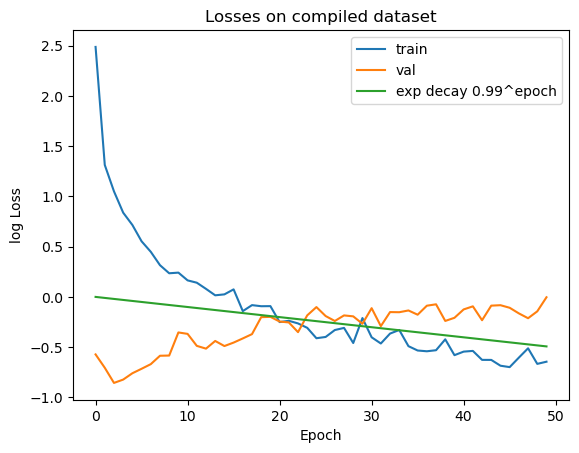

Loading latest model from model_checkpoints/broad_tuning/broad_tuning_2023-04-25_11-18-38.pt
cpu
Epoch 1: Train loss = 0.0000, Val loss = 5.1535
Epoch 2: Train loss = 0.0001, Val loss = 5.6782
Epoch 3: Train loss = 0.0001, Val loss = 6.2294
Epoch 4: Train loss = 0.0001, Val loss = 6.3904
Epoch 5: Train loss = 0.0000, Val loss = 6.5308
Epoch 6: Train loss = 0.0001, Val loss = 6.4464
Epoch 7: Train loss = 0.0001, Val loss = 6.4422
Epoch 8: Train loss = 0.0001, Val loss = 6.5003
Epoch 9: Train loss = 0.0002, Val loss = 6.3392
Epoch 10: Train loss = 0.0000, Val loss = 6.2572
Epoch 11: Train loss = 0.0002, Val loss = 6.3847
Epoch 12: Train loss = 0.0001, Val loss = 6.3118
Epoch 13: Train loss = 0.0001, Val loss = 6.1885
Epoch 14: Train loss = 0.0001, Val loss = 6.1043
Epoch 15: Train loss = 0.0001, Val loss = 6.1159
Epoch 16: Train loss = 0.0001, Val loss = 6.0586
Epoch 17: Train loss = 0.0000, Val loss = 6.0817
Epoch 18: Train loss = 0.0001, Val loss = 6.0616
Epoch 19: Train loss = 0.0000,

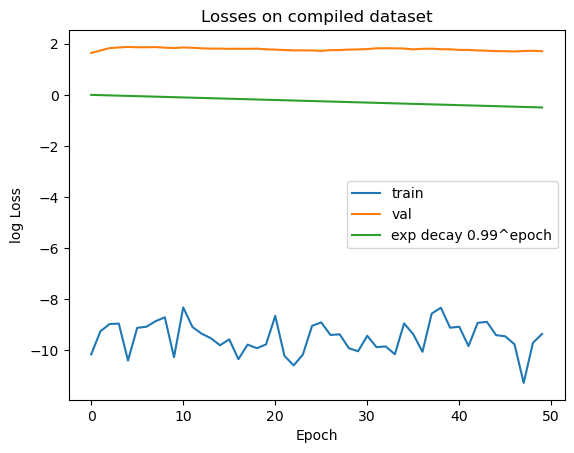

cpu
Epoch 1: Train loss = 4.4521, Val loss = 0.4588
Epoch 2: Train loss = 3.1547, Val loss = 0.4561
Epoch 3: Train loss = 2.6095, Val loss = 0.4776
Epoch 4: Train loss = 2.2651, Val loss = 0.5215
Epoch 5: Train loss = 2.1287, Val loss = 0.5235
Epoch 6: Train loss = 1.9483, Val loss = 0.5572
Epoch 7: Train loss = 1.7432, Val loss = 0.5771
Epoch 8: Train loss = 1.5462, Val loss = 0.6382
Epoch 9: Train loss = 1.4933, Val loss = 0.6334
Epoch 10: Train loss = 1.4033, Val loss = 0.6511
Epoch 11: Train loss = 1.3783, Val loss = 0.5921
Epoch 12: Train loss = 1.2918, Val loss = 0.6138
Epoch 13: Train loss = 1.1982, Val loss = 0.7031
Epoch 14: Train loss = 1.1144, Val loss = 0.6989
Epoch 15: Train loss = 1.1038, Val loss = 0.6668
Epoch 16: Train loss = 1.0722, Val loss = 0.7187
Epoch 17: Train loss = 1.0036, Val loss = 0.7027
Epoch 18: Train loss = 1.0098, Val loss = 0.7012
Epoch 19: Train loss = 0.9342, Val loss = 0.7148
Epoch 20: Train loss = 0.8822, Val loss = 0.7669
Epoch 21: Train loss = 0.

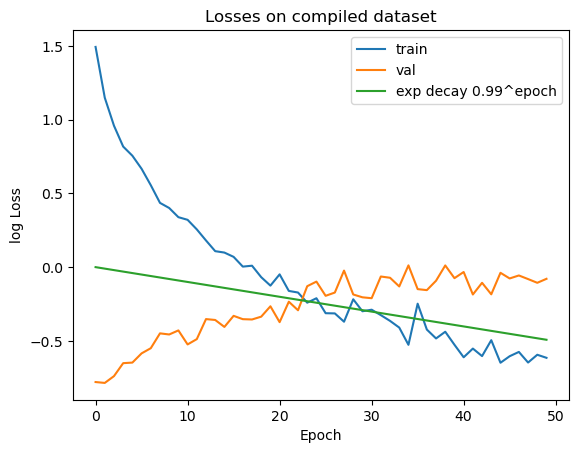

cpu
Epoch 1: Train loss = 0.2173, Val loss = 0.8834
Epoch 2: Train loss = 0.2199, Val loss = 0.7502
Epoch 3: Train loss = 0.1622, Val loss = 0.7573
Epoch 4: Train loss = 0.1561, Val loss = 1.0809
Epoch 5: Train loss = 0.1445, Val loss = 1.4557
Epoch 6: Train loss = 0.1319, Val loss = 1.4935
Epoch 7: Train loss = 0.1148, Val loss = 1.2786
Epoch 8: Train loss = 0.0952, Val loss = 1.0821
Epoch 9: Train loss = 0.0773, Val loss = 1.0009
Epoch 10: Train loss = 0.0596, Val loss = 1.1253
Epoch 11: Train loss = 0.0438, Val loss = 1.4686
Epoch 12: Train loss = 0.0309, Val loss = 1.7804
Epoch 13: Train loss = 0.0206, Val loss = 1.9509
Epoch 14: Train loss = 0.0137, Val loss = 2.2987
Epoch 15: Train loss = 0.0092, Val loss = 2.4928
Epoch 16: Train loss = 0.0063, Val loss = 2.5799
Epoch 17: Train loss = 0.0044, Val loss = 2.7616
Epoch 18: Train loss = 0.0033, Val loss = 2.8751
Epoch 19: Train loss = 0.0026, Val loss = 2.9770
Epoch 20: Train loss = 0.0021, Val loss = 3.2268
Epoch 21: Train loss = 0.

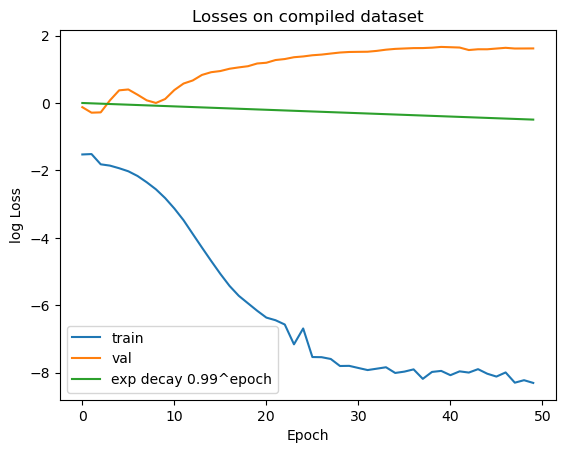

<Axes: title={'center': 'Losses on compiled dataset'}, xlabel='Epoch', ylabel='log Loss'>

In [46]:

# create dataset loaders

device = 'cpu'

# load in the broad tuned model
model = Classifier()
base_params["experiment_name"] = "broad_tuning"
base_params["checkpoint_dir"] = os.path.join(base_params["base_checkpoint_dir"], base_params["experiment_name"])
learning_rate = 1e-2
weight_decay = 0.0

model = load_model(model, base_params["checkpoint_dir"], latest=True)
#retrain on the clean ranked data

# base_params["experiment_name"] = "broad_tuning_ranked"
# base_params["checkpoint_dir"] = os.path.join(base_params["base_checkpoint_dir"], base_params["experiment_name"])
# os.makedirs(base_params["checkpoint_dir"], exist_ok=True)

model, train_losses, val_losses = train_model(model, clean_ranked_loader, validation_loader, num_epochs=50, lr=learning_rate, weight_decay=weight_decay, rank=rank)
plot_losses([train_losses, val_losses], title="Losses on compiled dataset")


# base_params["experiment_name"] = "broad_tuning"
# base_params["checkpoint_dir"] = os.path.join(base_params["base_checkpoint_dir"], base_params["experiment_name"])

model = load_model(model, base_params["checkpoint_dir"], latest=True)
#retrain on the federated ranked data
model, train_losses, val_losses = train_model(model, federated_ranked_loader, validation_loader, num_epochs=50, lr=learning_rate, weight_decay=weight_decay, rank=rank)
plot_losses([train_losses, val_losses], title="Losses on compiled dataset")


#try again from scratch
model = Classifier()
model, train_losses, val_losses = train_model(model, clean_ranked_loader, validation_loader, num_epochs=50, lr=learning_rate, weight_decay=weight_decay, rank=rank)
plot_losses([train_losses, val_losses], title="Losses on compiled dataset")

model = Classifier()
model, train_losses, val_losses = train_model(model, federated_ranked_loader, validation_loader, num_epochs=50, lr=learning_rate, weight_decay=weight_decay, rank=rank)
plot_losses([train_losses, val_losses], title="Losses on compiled dataset")


Loading latest model from model_checkpoints/broad_tuning/broad_tuning_2023-04-25_11-18-38.pt
cpu
Epoch 1: Train loss = 16.4517, Val loss = 0.6956
Epoch 2: Train loss = 4.9787, Val loss = 0.6907
Epoch 3: Train loss = 5.3423, Val loss = 0.6904
Epoch 4: Train loss = 5.4973, Val loss = 0.6918
Epoch 5: Train loss = 5.5118, Val loss = 0.6921
Epoch 6: Train loss = 5.5114, Val loss = 0.6919
Epoch 7: Train loss = 5.5122, Val loss = 0.6917
Epoch 8: Train loss = 5.5111, Val loss = 0.6920
Epoch 9: Train loss = 5.5114, Val loss = 0.6917
Epoch 10: Train loss = 5.5119, Val loss = 0.6920
Epoch 11: Train loss = 5.5112, Val loss = 0.6924
Epoch 12: Train loss = 5.5113, Val loss = 0.6921
Epoch 13: Train loss = 5.5116, Val loss = 0.6917
Epoch 14: Train loss = 5.5131, Val loss = 0.6920
Epoch 15: Train loss = 5.5119, Val loss = 0.6920
Epoch 16: Train loss = 5.5116, Val loss = 0.6919
Epoch 17: Train loss = 5.5125, Val loss = 0.6921
Epoch 18: Train loss = 5.5118, Val loss = 0.6917
Epoch 19: Train loss = 5.5122

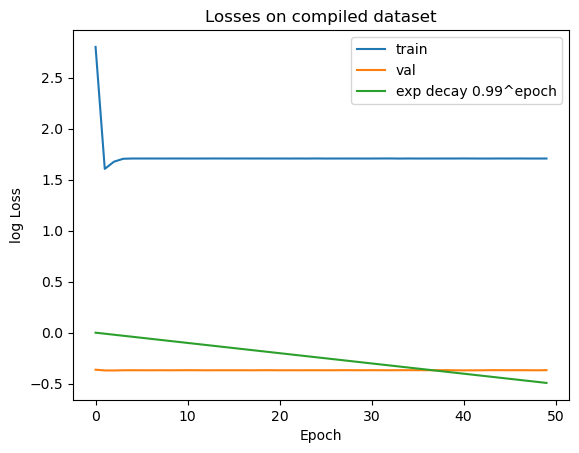

Loading latest model from model_checkpoints/broad_tuning/broad_tuning_2023-04-25_11-18-38.pt
cpu
Epoch 1: Train loss = 0.0001, Val loss = 2.8577
Epoch 2: Train loss = 0.0002, Val loss = 1.7901
Epoch 3: Train loss = 0.0004, Val loss = 1.1929
Epoch 4: Train loss = 0.0013, Val loss = 0.9072
Epoch 5: Train loss = 0.0033, Val loss = 0.7391
Epoch 6: Train loss = 0.0081, Val loss = 0.6790
Epoch 7: Train loss = 0.0165, Val loss = 0.6767
Epoch 8: Train loss = 0.0264, Val loss = 0.6767
Epoch 9: Train loss = 0.0380, Val loss = 0.6497
Epoch 10: Train loss = 0.0479, Val loss = 0.6305
Epoch 11: Train loss = 0.0548, Val loss = 0.6316
Epoch 12: Train loss = 0.0588, Val loss = 0.6558
Epoch 13: Train loss = 0.0619, Val loss = 0.6832
Epoch 14: Train loss = 0.0651, Val loss = 0.7004
Epoch 15: Train loss = 0.0657, Val loss = 0.7080
Epoch 16: Train loss = 0.0653, Val loss = 0.7129
Epoch 17: Train loss = 0.0661, Val loss = 0.7151
Epoch 18: Train loss = 0.0675, Val loss = 0.7167
Epoch 19: Train loss = 0.0709,

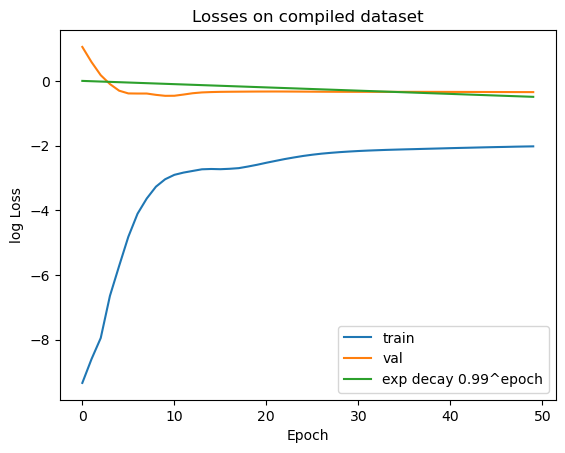

cpu
Epoch 1: Train loss = 5.0932, Val loss = 0.6814
Epoch 2: Train loss = 5.0347, Val loss = 0.6798
Epoch 3: Train loss = 5.3014, Val loss = 0.6885
Epoch 4: Train loss = 5.4969, Val loss = 0.6921
Epoch 5: Train loss = 5.5131, Val loss = 0.6921
Epoch 6: Train loss = 5.5126, Val loss = 0.6917
Epoch 7: Train loss = 5.5105, Val loss = 0.6921
Epoch 8: Train loss = 5.5119, Val loss = 0.6922
Epoch 9: Train loss = 5.5121, Val loss = 0.6919
Epoch 10: Train loss = 5.5115, Val loss = 0.6924
Epoch 11: Train loss = 5.5116, Val loss = 0.6917
Epoch 12: Train loss = 5.5115, Val loss = 0.6920
Epoch 13: Train loss = 5.5109, Val loss = 0.6922
Epoch 14: Train loss = 5.5118, Val loss = 0.6927
Epoch 15: Train loss = 5.5141, Val loss = 0.6917
Epoch 16: Train loss = 5.5121, Val loss = 0.6921
Epoch 17: Train loss = 5.5132, Val loss = 0.6917
Epoch 18: Train loss = 5.5111, Val loss = 0.6918
Epoch 19: Train loss = 5.5113, Val loss = 0.6920
Epoch 20: Train loss = 5.5137, Val loss = 0.6921
Epoch 21: Train loss = 5.

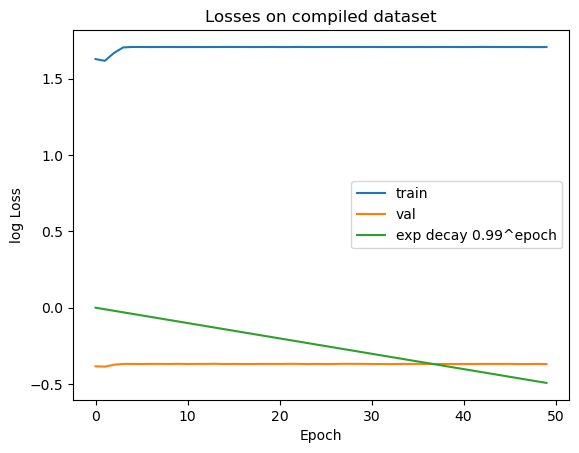

cpu
Epoch 1: Train loss = 0.1953, Val loss = 0.6909
Epoch 2: Train loss = 0.1863, Val loss = 0.6902
Epoch 3: Train loss = 0.1752, Val loss = 0.6902
Epoch 4: Train loss = 0.1754, Val loss = 0.6903
Epoch 5: Train loss = 0.1769, Val loss = 0.6904
Epoch 6: Train loss = 0.1732, Val loss = 0.6911
Epoch 7: Train loss = 0.1670, Val loss = 0.6929
Epoch 8: Train loss = 0.1602, Val loss = 0.6953
Epoch 9: Train loss = 0.1574, Val loss = 0.6974
Epoch 10: Train loss = 0.1585, Val loss = 0.6971
Epoch 11: Train loss = 0.1536, Val loss = 0.6985
Epoch 12: Train loss = 0.1495, Val loss = 0.7008
Epoch 13: Train loss = 0.1568, Val loss = 0.6991
Epoch 14: Train loss = 0.1541, Val loss = 0.6971
Epoch 15: Train loss = 0.1483, Val loss = 0.6993
Epoch 16: Train loss = 0.1561, Val loss = 0.6993
Epoch 17: Train loss = 0.1513, Val loss = 0.7003
Epoch 18: Train loss = 0.1494, Val loss = 0.7025
Epoch 19: Train loss = 0.1502, Val loss = 0.7025
Epoch 20: Train loss = 0.1461, Val loss = 0.7032
Epoch 21: Train loss = 0.

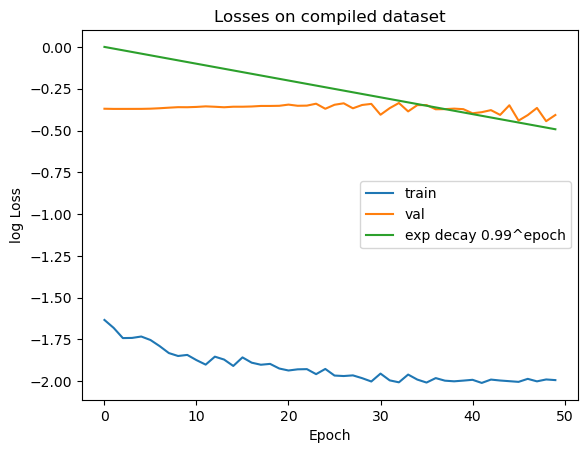

<Axes: title={'center': 'Losses on compiled dataset'}, xlabel='Epoch', ylabel='log Loss'>

In [47]:

# create dataset loaders

device = 'cpu'

# load in the broad tuned model
model = Classifier()
base_params["experiment_name"] = "broad_tuning"
base_params["checkpoint_dir"] = os.path.join(base_params["base_checkpoint_dir"], base_params["experiment_name"])
learning_rate = 1e-2
weight_decay = 0.1

model = load_model(model, base_params["checkpoint_dir"], latest=True)
#retrain on the clean ranked data

# base_params["experiment_name"] = "broad_tuning_ranked"
# base_params["checkpoint_dir"] = os.path.join(base_params["base_checkpoint_dir"], base_params["experiment_name"])
# os.makedirs(base_params["checkpoint_dir"], exist_ok=True)

model, train_losses, val_losses = train_model(model, clean_ranked_loader, validation_loader, num_epochs=50, lr=learning_rate, weight_decay=weight_decay, rank=rank)
plot_losses([train_losses, val_losses], title="Losses on compiled dataset")


# base_params["experiment_name"] = "broad_tuning"
# base_params["checkpoint_dir"] = os.path.join(base_params["base_checkpoint_dir"], base_params["experiment_name"])

model = load_model(model, base_params["checkpoint_dir"], latest=True)
#retrain on the federated ranked data
model, train_losses, val_losses = train_model(model, federated_ranked_loader, validation_loader, num_epochs=50, lr=learning_rate, weight_decay=weight_decay, rank=rank)
plot_losses([train_losses, val_losses], title="Losses on compiled dataset")


#try again from scratch
model = Classifier()
model, train_losses, val_losses = train_model(model, clean_ranked_loader, validation_loader, num_epochs=50, lr=learning_rate, weight_decay=weight_decay, rank=rank)
plot_losses([train_losses, val_losses], title="Losses on compiled dataset")

model = Classifier()
model, train_losses, val_losses = train_model(model, federated_ranked_loader, validation_loader, num_epochs=50, lr=learning_rate, weight_decay=weight_decay, rank=rank)
plot_losses([train_losses, val_losses], title="Losses on compiled dataset")


Loading latest model from model_checkpoints/broad_tuning/broad_tuning_2023-04-25_11-18-38.pt
cpu
Epoch 1: Train loss = 45.8856, Val loss = 4.2926
Epoch 2: Train loss = 33.2043, Val loss = 3.1297
Epoch 3: Train loss = 23.2693, Val loss = 2.2384
Epoch 4: Train loss = 16.9376, Val loss = 1.4925
Epoch 5: Train loss = 11.9441, Val loss = 1.1024
Epoch 6: Train loss = 8.7277, Val loss = 0.8420
Epoch 7: Train loss = 6.8011, Val loss = 0.7141
Epoch 8: Train loss = 5.5725, Val loss = 0.6296
Epoch 9: Train loss = 4.8627, Val loss = 0.5783
Epoch 10: Train loss = 4.4599, Val loss = 0.5198
Final: Train loss = 4.4599, Val loss = 0.5198


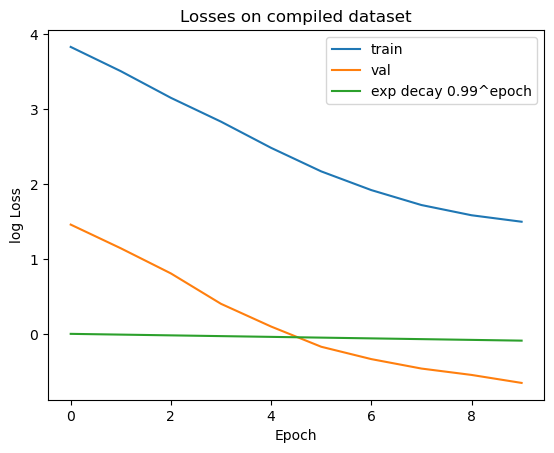

Loading latest model from model_checkpoints/broad_tuning/broad_tuning_2023-04-25_11-18-38.pt
cpu
Epoch 1: Train loss = 0.0001, Val loss = 4.9348
Epoch 2: Train loss = 0.0001, Val loss = 4.6348
Epoch 3: Train loss = 0.0001, Val loss = 4.5156
Epoch 4: Train loss = 0.0001, Val loss = 4.3584
Epoch 5: Train loss = 0.0001, Val loss = 3.9962
Epoch 6: Train loss = 0.0001, Val loss = 3.9132
Epoch 7: Train loss = 0.0001, Val loss = 3.8360
Epoch 8: Train loss = 0.0001, Val loss = 3.5493
Epoch 9: Train loss = 0.0001, Val loss = 3.3768
Epoch 10: Train loss = 0.0001, Val loss = 3.2619
Final: Train loss = 0.0001, Val loss = 3.2619


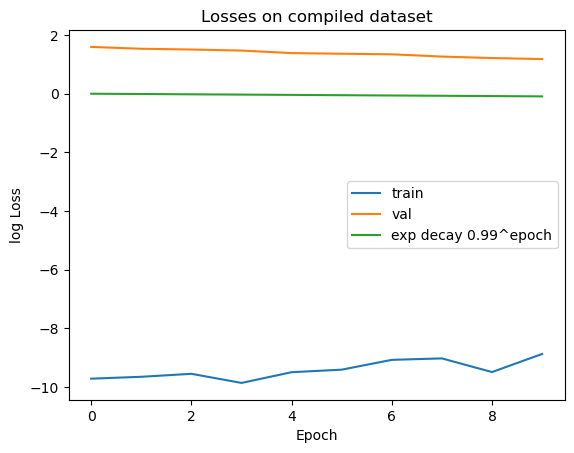

cpu
Epoch 1: Train loss = 4.6530, Val loss = 0.6617
Epoch 2: Train loss = 4.5716, Val loss = 0.5575
Epoch 3: Train loss = 4.5992, Val loss = 0.5611
Epoch 4: Train loss = 4.5705, Val loss = 0.5859
Epoch 5: Train loss = 4.6004, Val loss = 0.6144
Epoch 6: Train loss = 4.6438, Val loss = 0.5911
Epoch 7: Train loss = 4.6342, Val loss = 0.6108
Epoch 8: Train loss = 4.6738, Val loss = 0.6000
Epoch 9: Train loss = 4.6623, Val loss = 0.5766
Epoch 10: Train loss = 4.6864, Val loss = 0.5869
Final: Train loss = 4.6864, Val loss = 0.5869


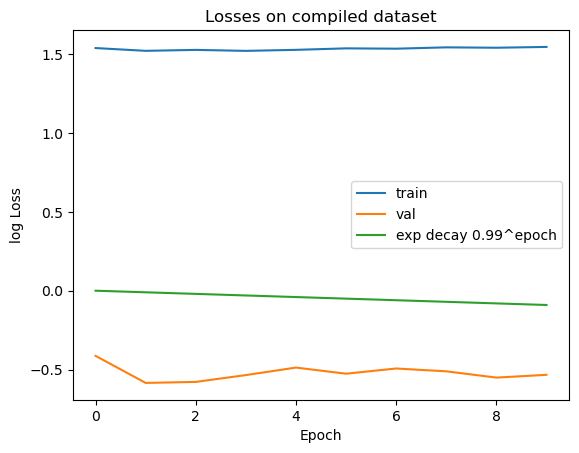

cpu
Epoch 1: Train loss = 0.2032, Val loss = 0.6915
Epoch 2: Train loss = 0.1992, Val loss = 0.6905
Epoch 3: Train loss = 0.1950, Val loss = 0.6900
Epoch 4: Train loss = 0.1916, Val loss = 0.6898
Epoch 5: Train loss = 0.1877, Val loss = 0.6898
Epoch 6: Train loss = 0.1844, Val loss = 0.6899
Epoch 7: Train loss = 0.1802, Val loss = 0.6902
Epoch 8: Train loss = 0.1760, Val loss = 0.6906
Epoch 9: Train loss = 0.1712, Val loss = 0.6912
Epoch 10: Train loss = 0.1660, Val loss = 0.6919
Final: Train loss = 0.1660, Val loss = 0.6919


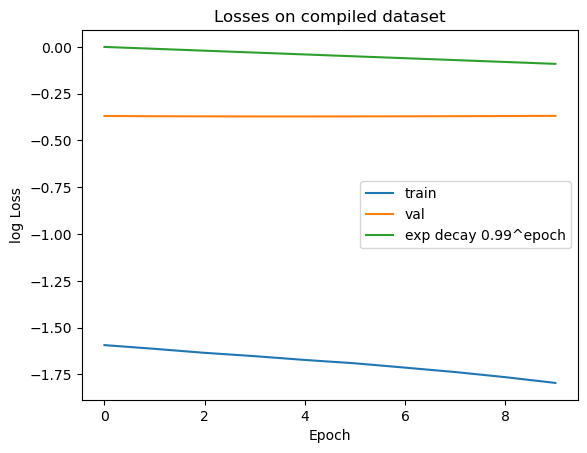

<Axes: title={'center': 'Losses on compiled dataset'}, xlabel='Epoch', ylabel='log Loss'>

In [42]:

# create dataset loaders

device = 'cpu'

# load in the broad tuned model
model = Classifier()
base_params["experiment_name"] = "broad_tuning"
base_params["checkpoint_dir"] = os.path.join(base_params["base_checkpoint_dir"], base_params["experiment_name"])
learning_rate = 1e-3
weight_decay = 0.1

model = load_model(model, base_params["checkpoint_dir"], latest=True)
#retrain on the clean ranked data

# base_params["experiment_name"] = "broad_tuning_ranked"
# base_params["checkpoint_dir"] = os.path.join(base_params["base_checkpoint_dir"], base_params["experiment_name"])
# os.makedirs(base_params["checkpoint_dir"], exist_ok=True)

model, train_losses, val_losses = train_model(model, clean_ranked_loader, validation_loader, num_epochs=10, lr=learning_rate, weight_decay=weight_decay, rank=rank)
plot_losses([train_losses, val_losses], title="Losses on compiled dataset")


# base_params["experiment_name"] = "broad_tuning"
# base_params["checkpoint_dir"] = os.path.join(base_params["base_checkpoint_dir"], base_params["experiment_name"])

model = load_model(model, base_params["checkpoint_dir"], latest=True)
#retrain on the federated ranked data
model, train_losses, val_losses = train_model(model, federated_ranked_loader, validation_loader, num_epochs=10, lr=learning_rate, weight_decay=weight_decay, rank=rank)
plot_losses([train_losses, val_losses], title="Losses on compiled dataset")


#try again from scratch
model = Classifier()
model, train_losses, val_losses = train_model(model, clean_ranked_loader, validation_loader, num_epochs=10, lr=learning_rate, weight_decay=weight_decay, rank=rank)
plot_losses([train_losses, val_losses], title="Losses on compiled dataset")

model = Classifier()
model, train_losses, val_losses = train_model(model, federated_ranked_loader, validation_loader, num_epochs=10, lr=learning_rate, weight_decay=weight_decay, rank=rank)
plot_losses([train_losses, val_losses], title="Losses on compiled dataset")


In [68]:

# create dataset loaders

device = 'cpu'

# load in the broad tuned model
model = Classifier()
base_params["experiment_name"] = "broad_tuning"
base_params["checkpoint_dir"] = os.path.join(base_params["base_checkpoint_dir"], base_params["experiment_name"])
learning_rate = 1e-3
weight_decay = 0.0

model = load_model(model, base_params["checkpoint_dir"], latest=True)
#retrain on the clean ranked data

# base_params["experiment_name"] = "broad_tuning_ranked"
# base_params["checkpoint_dir"] = os.path.join(base_params["base_checkpoint_dir"], base_params["experiment_name"])
# os.makedirs(base_params["checkpoint_dir"], exist_ok=True)

model, train_losses, val_losses = train_model(model, clean_ranked_loader, validation_loader, num_epochs=10, lr=learning_rate, weight_decay=weight_decay, rank=rank)
plot_losses([train_losses, val_losses], title="Losses on compiled dataset")


# base_params["experiment_name"] = "broad_tuning"
# base_params["checkpoint_dir"] = os.path.join(base_params["base_checkpoint_dir"], base_params["experiment_name"])

model = load_model(model, base_params["checkpoint_dir"], latest=True)
#retrain on the federated ranked data
model, train_losses, val_losses = train_model(model, federated_ranked_loader, validation_loader, num_epochs=10, lr=learning_rate, weight_decay=weight_decay, rank=rank)
plot_losses([train_losses, val_losses], title="Losses on compiled dataset")


#try again from scratch
model = Classifier()
model, train_losses, val_losses = train_model(model, clean_ranked_loader, validation_loader, num_epochs=10, lr=learning_rate, weight_decay=weight_decay, rank=rank)
plot_losses([train_losses, val_losses], title="Losses on compiled dataset")

model = Classifier()
model, train_losses, val_losses = train_model(model, federated_ranked_loader, validation_loader, num_epochs=10, lr=learning_rate, weight_decay=weight_decay, rank=rank)
plot_losses([train_losses, val_losses], title="Losses on compiled dataset")


Loading latest model from model_checkpoints/broad_tuning/broad_tuning_2023-04-25_11-18-38.pt
cpu
Epoch 1: Train loss = 40.1726, Val loss = 3.0458, Val accuracy = 66.2329
Epoch 2: Train loss = 19.9782, Val loss = 1.5935, Val accuracy = 64.9781


KeyboardInterrupt: 

In [ ]:
### Gradual Fine Tuning with similarity ranking

device = 'cpu'

# load in the broad tuned model
model = Classifier()
base_params["experiment_name"] = "broad_tuning"
base_params["checkpoint_dir"] = os.path.join(base_params["base_checkpoint_dir"], base_params["experiment_name"])
learning_rate = 1e-3
weight_decay = 0.0

model = load_model(model, base_params["checkpoint_dir"], latest=True)




In [79]:
import copy
import math
import os
from models import compile_and_train_dataset, gradual_fine_tuning

    # # Set the parameters for gradual fine-tuning
    # if gradual_FT_params is None:
    #     gradual_FT_params = copy.deepcopy(base_params)
    #     gradual_FT_params["experiment_name"] = "gradual_FT"
    #     gradual_FT_params["checkpoint_dir"] = os.path.join(gradual_FT_params["base_checkpoint_dir"], gradual_FT_params["experiment_name"])
    #     gradual_FT_params["max_epochs"] = 10
    #     gradual_FT_params["batch_size"] = 2**9
    #     gradual_FT_params["learning_rate"] = 1e-3
    #     gradual_FT_params["weight_decay"] = 0.0
    # else:
    #     try:
    #         rank = gradual_FT_params["rank"]
    #     except:
    #         print("Rank set to: "+str(rank))


In [211]:
# Gradual fine tuning testing - each finetuning step is 1/2 the size of the previous step for the federated dataset
# Each step we compile a dataset with the federated data and the clean data and then train the model on that dataset
import copy
device = 'cpu'
# load in the broad tuned model
model = Classifier()
#create placeholder for grad_FT_model
Grad_FT_model = None

# broad tuning on federated dataset
base_params["experiment_name"] = "broad_tuning"
base_params["checkpoint_dir"] = os.path.join(base_params["base_checkpoint_dir"], base_params["experiment_name"])

model = load_model(model, base_params["checkpoint_dir"], latest=True)
# model, train_losses, val_losses = train_model(model, federated_loader, validation_loader, num_epochs=20, lr=learning_rate, weight_decay=weight_decay)
# plot_losses([train_losses, val_losses], title="Losses on compiled dataset")



# set the parameters for the gradual fine tuning
gradual_FT_params = copy.deepcopy(base_params)
gradual_FT_params["experiment_name"] = "gradual_FT"
gradual_FT_params["checkpoint_dir"] = os.path.join(gradual_FT_params["base_checkpoint_dir"], gradual_FT_params["experiment_name"])
gradual_FT_params["learning_rate"] = 1e-3
gradual_FT_params["weight_decay"] = 0.0
gradual_FT_params["max_epochs"] = 10

rank = "Tanimoto"

Grad_FT_model, train_losses, val_losses = gradual_fine_tuning(model, federated_data=federated_data_ranked, clean_data=clean_data_ranked, gradual_FT_params=gradual_FT_params, validation_loader=validation_loader, rank=rank)


# final step with the clean data
temp_params = copy.deepcopy(gradual_FT_params)

temp_params["experiment_name"] = gradual_FT_params["experiment_name"] + "_step_{}".format(-1)

Grad_FT_model, train_losses, val_losses = train_model(model, clean_ranked_loader, validation_loader, num_epochs=gradual_FT_params["max_epochs"], lr=1e-3, rank=rank)

plot_losses([train_losses, val_losses], title="Losses on compiled dataset"+" "+temp_params["experiment_name"])
save_model(model, params=temp_params)




Loading latest model from model_checkpoints/broad_tuning/broad_tuning_2023-04-25_11-18-38.pt
Datasets ranked by Tanimoto
Initial size of dataset: 50000
Sampling 50.0% of the dataset
Final size of dataset: 25000
Initial size of dataset: 6218
Sampling 100% of the dataset
Final size of dataset: 6218


TypeError: train_model() got an unexpected keyword argument 'weight_decay'